<a href="https://colab.research.google.com/github/Dev-py-r/python-from-scratch/blob/master/Rec_Sys.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import sys
import pickle

In [14]:
movies = pd.read_csv('/movie.csv')
ratings = pd.read_csv('/rating.csv')
tags = pd.read_csv('/tag.csv')

In [15]:
movies.head(2)

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy


In [16]:
ratings.head(2)

,userId,movieId,rating,timestamp
0,1,2.0,3.5,2005-04-02 23:53:47
1,1,29.0,3.5,2005-04-02 23:31:16


In [18]:
tags.head(2)

,userId,movieId,tag,timestamp
0,18,4141,Mark Waters,2009-04-24 18:19:40
1,65,208,dark hero,2013-05-10 01:41:18


In [20]:
movies['genres']=movies['genres'].str.replace('|',' ')

In [21]:
len(movies.movieId.unique())

27278

In [22]:
len(ratings.movieId.unique())

16552

In [23]:
#limit rating to user rating that have rated more than 55 movies-- 
#Otherwise it becomes impossible to pivot the rating dataframe later for collaborative filtering.
ratings_f = ratings.groupby('userId').filter(lambda x: len(x) >= 55)

In [24]:
# list the movie titles that survive the filtering
movie_list_rating = ratings_f.movieId.unique().tolist()

In [25]:
# no worries: we have kept 97% of the original movie titles in ratings data frame
len(ratings_f.movieId.unique())/len(movies.movieId.unique())*100

60.411320478040906

In [26]:
# but only 57% of the users 
len(ratings_f.userId.unique())/len(ratings.userId.unique())*100

58.475442043222

In [27]:
#filter the movies data frame
movies = movies[movies.movieId.isin(movie_list_rating)]

In [28]:
movies.head(3)

,movieId,title,genres
0,1,Toy Story (1995),Adventure Animation Children Comedy Fantasy
1,2,Jumanji (1995),Adventure Children Fantasy
2,3,Grumpier Old Men (1995),Comedy Romance


In [29]:
# map movie to id:
Mapping_file = dict(zip(movies.title.tolist(),movies.movieId.tolist()))

In [30]:
tags.drop(['timestamp'],1,inplace=True)
ratings_f.drop(['timestamp'],1,inplace=True)

Merge the movies and the tags data frame and create a etadata tag for each movie:

In [31]:
# create a mixed dataframe of movies title, genres 
# and all user tags given to each movie
mixed = pd.merge(movies,tags,on='movieId',how='left')
mixed.head(3)

,movieId,title,genres,userId,tag
0,1,Toy Story (1995),Adventure Animation Children Comedy Fantasy,1644.0,Watched
1,1,Toy Story (1995),Adventure Animation Children Comedy Fantasy,1741.0,computer animation
2,1,Toy Story (1995),Adventure Animation Children Comedy Fantasy,1741.0,Disney animated feature


In [32]:
#create metadata from tags and genres
mixed.fillna("", inplace=True)
mixed = pd.DataFrame(mixed.groupby('movieId')['tag'].apply(lambda x: "%s"%' '.join(x)))
Final = pd.merge(movies,mixed, on ='movieId',how = 'left')
Final['metadata'] = Final[['tag','genres']].apply(lambda x: ' '.join(x),axis = 1)
Final[['movieId','title','metadata']].head(3)

,movieId,title,metadata
0,1,Toy Story (1995),Watched computer animation Disney animated fea...
1,2,Jumanji (1995),time travel adapted from:book board game child...
2,3,Grumpier Old Men (1995),old people that is actually funny sequel fever...


In [33]:
Final.shape

(16479, 5)

In [34]:
Final.loc[1,'metadata']

'time travel adapted from:book board game childhood recaptured game herds of CGI animals scary see also:Zathura time time travel board game fantasy Robin Williams scary time travel Robin Williams Joe Johnston Robin Williams kid flick jungle Robin Williams board game Robin Williams animals Lebbat Robin Williams time travel adventure Robin Williams Children Fantasy Robin Williams Dynamic CGI Action Kirsten Dunst Robin Williams Robin Williams fantasy kid flick animals animals fantasy For children fantasy adapted from:book childish Children kid flick time travel Joe Johnston fantasy Robin Williams time travel animals board game children fantasy Kirsten Dunst Robin Williams time travel board game time travel Children kid flick Filmed in BC fantasy Robin Williams animals bad cgi based on a book board game Chris Van Allsburg Robin Williams Robin Williams game magic board game monkey adapted from:book animals bad cgi based on a book board game childhood recaptured Children Chris Van Allsburg f

# Creating a content latent matrix from movie metadata:

# tf-idf vectors and truncated SVD :

In [35]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf.fit_transform(Final['metadata'])
tfidf_df = pd.DataFrame(tfidf_matrix.toarray() , index=Final.index.tolist())
print(tfidf_df.shape)

(16479, 22046)


In [36]:
tfidf_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,22006,22007,22008,22009,22010,22011,22012,22013,22014,22015,22016,22017,22018,22019,22020,22021,22022,22023,22024,22025,22026,22027,22028,22029,22030,22031,22032,22033,22034,22035,22036,22037,22038,22039,22040,22041,22042,22043,22044,22045
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# The first 200 components explain over 50% of the variance:

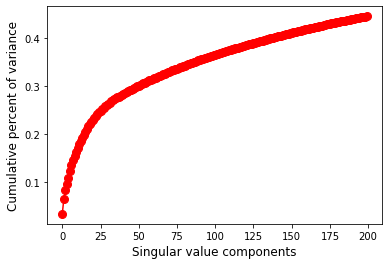

In [37]:
#Compress with SVD
from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components = 200 )
latent_matrix = svd.fit_transform(tfidf_df)
#plot var explained to see what latent dimensions to use
explained = svd.explained_variance_ratio_.cumsum()
plt.plot(explained,'.-', ms = 16, color = 'red')
plt.xlabel('Singular value components',fontsize = 12)
plt.ylabel('Cumulative percent of variance',fontsize = 12)
plt.show()

In [38]:
#number of latent dimensions to keep
n = 200 
latent_matrix_1_df = pd.DataFrame(latent_matrix[:,0:n], index=Final.title.tolist())

In [39]:
# our content latent matrix:
latent_matrix.shape

(16479, 200)

# Creating a collaborative latent matrix from user ratings:

In [40]:
ratings_f.head()

,userId,movieId,rating
0,1,2.0,3.5
1,1,29.0,3.5
2,1,32.0,3.5
3,1,47.0,3.5
4,1,50.0,3.5


In [41]:
ratings_f1 = pd.merge(movies[['movieId']], ratings_f, on="movieId", how="right")

In [42]:
ratings_f1.head(1)

,movieId,userId,rating
0,2,1,3.5


In [44]:
ratings_f2 = ratings_f1.pivot(index = 'movieId', columns ='userId', values = 'rating').fillna(0)

In [45]:
ratings_f2.head(2)

userId,1,2,3,5,7,8,11,13,14,16,18,21,22,23,24,25,26,27,29,31,32,34,35,38,40,41,43,46,48,50,51,53,54,56,58,60,61,65,67,69,...,12646,12647,12648,12649,12653,12655,12659,12660,12665,12666,12668,12669,12670,12671,12672,12673,12674,12676,12677,12678,12679,12681,12683,12684,12687,12688,12695,12696,12700,12704,12705,12706,12707,12710,12711,12717,12718,12719,12720,12722
movieId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,4.0,0.0,0.0,4.0,4.5,4.0,4.5,3.0,0.0,0.0,3.0,4.0,4.0,0.0,0.0,0.0,0.0,3.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,4.0,0.0,5.0,0.0,0.0,0.0,0.0,4.0,...,0.0,0.0,0.0,3.5,0.0,0.0,4.5,0.0,3.0,4.0,4.0,3.0,0.0,4.5,4.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,4.0,0.0,0.0,5.0,0.0,5.0,4.0,4.0,5.0,0.0,0.0,4.0,0.0,0.0,4.0,0.0,5.0,3.0
2,3.5,0.0,0.0,3.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.5,0.0,0.0,3.0,0.0,0.0,4.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,3.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,3.0,0.0,0.0,0.0,4.0,4.0,2.0


In [47]:
ratings_f2.shape

(16479, 7441)

In [48]:
len(ratings_f.movieId.unique())

16479

In [49]:
from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components=200)
latent_matrix_2 = svd.fit_transform(ratings_f2)
latent_matrix_2_df = pd.DataFrame(latent_matrix_2,index=Final.title.tolist())

In [50]:
latent_matrix_2_df.shape

(16479, 200)

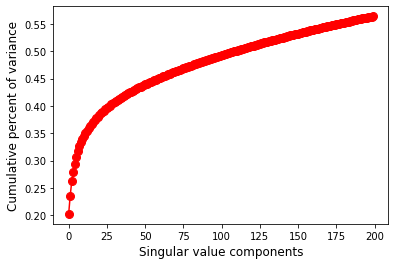

In [51]:
# plot variance expalined to see what latent dimensions to use
explained = svd.explained_variance_ratio_.cumsum()
plt.plot(explained, '.-', ms = 16, color='red')
plt.xlabel('Singular value components', fontsize= 12)
plt.ylabel('Cumulative percent of variance', fontsize=12)        
plt.show()

In [53]:
latent_matrix_1_df.head(2)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199
Toy Story (1995),0.036071,0.056222,0.022826,0.010710,0.014805,0.037847,0.019743,0.157266,0.002189,-0.001866,0.020170,-0.193205,0.210724,-0.104091,0.037804,-0.067183,-0.075430,-0.039784,0.008555,-0.025506,0.118818,-0.297442,0.000270,0.038065,-0.042269,-0.272353,-0.015820,-0.000149,0.034039,-0.021600,-0.006169,-0.013932,-0.008111,-0.030840,0.037354,0.017003,0.069037,-0.028461,-0.004253,-0.063208,...,-0.029623,0.005576,0.053797,-0.029259,0.016005,0.053320,0.037623,0.024344,0.017253,-0.024211,0.014132,-0.051650,0.013343,-0.006564,-0.014941,-0.040011,-0.055876,0.030125,0.019939,-0.004654,0.021688,0.001812,0.030979,-0.056825,-0.011139,-0.010404,-0.025063,0.048201,0.018556,0.026365,0.069638,-0.002615,-0.032338,0.002834,0.090364,0.061234,-0.026927,0.006585,-0.101294,0.013002
Jumanji (1995),0.016446,0.013510,0.035501,0.018349,0.006450,0.008880,0.020190,0.100256,-0.000589,0.003873,0.012178,-0.107869,0.079077,-0.040341,0.030783,-0.024637,-0.006185,-0.019870,0.095274,-0.036055,-0.038906,0.027230,0.126134,0.027349,-0.004520,0.064984,0.001869,-0.024595,0.027275,-0.006463,0.004022,-0.066015,-0.048345,-0.098601,-0.007166,0.177721,0.156969,0.029363,0.068867,-0.083014,...,-0.037676,0.056484,-0.071476,0.050386,-0.002327,0.067162,0.012279,0.040853,-0.098693,-0.037479,0.043529,0.039504,-0.025396,0.027096,-0.012929,0.033655,-0.015648,-0.003824,0.020956,0.017593,-0.000901,0.004994,-0.017710,-0.013598,0.007609,0.057900,-0.025667,0.041416,-0.003501,0.045766,-0.026748,-0.019024,-0.027964,-0.017987,0.010202,-0.020676,-0.025974,-0.011637,-0.012603,-0.010457


In [54]:
latent_matrix_2_df.head(2)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199
Toy Story (1995),172.843624,0.122888,46.198511,20.058670,5.715030,47.651960,-19.194648,18.730150,-18.133594,-5.33206,1.699015,10.329319,-29.414955,7.638080,11.172903,10.560694,1.058837,38.365497,-9.940576,4.087586,23.903630,22.687832,21.354039,14.311353,-13.343493,-18.025798,15.168503,6.310644,-4.214365,-5.315240,7.891713,-5.988961,15.091094,-18.708143,14.785802,-9.629416,11.045787,25.162538,16.448865,8.124673,...,7.854280,5.468163,-5.963140,1.063812,0.605438,-3.715925,-0.799174,-11.286953,-4.256728,5.879606,-4.381676,-2.306119,-5.395288,-2.789434,2.398263,-2.595731,9.440629,0.824382,1.739494,-5.392704,-0.190036,-0.756822,0.594496,-4.195026,10.520528,-3.160609,-2.102377,5.821405,4.907099,2.607980,-6.582353,1.240953,-1.982341,-3.808108,6.361418,5.192985,-4.689182,-2.359457,3.868690,-0.999899
Jumanji (1995),79.057356,1.422486,48.863948,-16.856374,-12.460965,5.329509,-19.999752,13.280174,3.164447,4.13461,10.739529,6.070193,7.981303,-16.761926,3.301039,2.372827,4.976617,4.786386,-13.264474,-0.547616,3.380431,-8.256898,1.790500,1.537820,-1.577315,-8.438957,0.024640,-7.096468,-3.626270,-7.954789,-1.223914,2.476704,4.374677,-2.349104,-13.334368,3.710491,3.929164,4.849065,2.675219,-4.101131,...,8.464764,1.604966,2.146902,-0.486648,0.591596,4.753055,6.448002,0.606960,-8.068707,-6.689915,6.678279,-8.354061,-2.051758,-0.257639,5.177505,-10.087467,7.979151,2.715679,1.812356,1.907803,1.678550,1.293009,-1.185842,-6.011018,-2.403664,5.993981,-0.056213,-8.447140,8.501207,5.112543,1.662624,0.628105,-0.333096,3.926561,-9.770134,-3.355255,-1.947698,-1.342267,3.731208,2.045424


# Running a content / collaborative and hybrid cosine Similarity:

In [55]:
from sklearn.metrics.pairwise import cosine_similarity
# take the latent vectors for a selected movie from both content 
# and collaborative matrixes
a_1 = np.array(latent_matrix_1_df.loc['Toy Story (1995)']).reshape(1, -1)
a_2 = np.array(latent_matrix_2_df.loc['Toy Story (1995)']).reshape(1, -1)

# calculate the similartity of this movie with the others in the list
score_1 = cosine_similarity(latent_matrix_1_df, a_1).reshape(-1)
score_2 = cosine_similarity(latent_matrix_2_df, a_2).reshape(-1)

# an average measure of both content and collaborative 
hybrid = ((score_1 + score_2)/2.0)

# form a data frame of similar movies 
dictDf = {'content': score_1 , 'collaborative': score_2, 'hybrid': hybrid} 
similar = pd.DataFrame(dictDf, index = latent_matrix_1_df.index )

#sort it on the basis of either: content, collaborative or hybrid, 
# here : content
similar.sort_values('hybrid', ascending=False, inplace=True)

similar[1:].head(11)

,content,collaborative,hybrid
Toy Story 2 (1999),0.962383,0.730271,0.846327
"Bug's Life, A (1998)",0.905950,0.649217,0.777584
"Monsters, Inc. (2001)",0.883367,0.613576,0.748471
Finding Nemo (2003),0.877212,0.598285,0.737749
"Incredibles, The (2004)",0.785848,0.565448,0.675648
Ice Age (2002),0.876382,0.462006,0.669194
Ratatouille (2007),0.896259,0.404617,0.650438
Antz (1998),0.743474,0.539483,0.641478
Toy Story 3 (2010),0.852141,0.402003,0.627072
Shrek (2001),0.590506,0.616892,0.603699


We could use the similarity information we gained from item-item collaborative filtering to compute a rating prediction,𝑟[i][u], for an item (𝑖) by a user (𝑢) where the rating is missing. Namely by taking a weighted average on the rating values of the top K nearest neighbours of item (𝑖).